# 시계열 예측
미래 예측이 가능하기 위한 전제 : 안정적(Stationary) 데이터에 대해서만 미래 예측이 가능하다.
- stationary : 시계열 데이터의 통계적 특성이 변하지 않는다. 

## ARIMA 
'Stationary Time-Series'와 'Stationarity'를 '정상시계열', '정상성'으로 번역하나 '정상'의 의미를 '시계열의 특성을 안정적으로 나타내는' 특성이라고 해석하는게 더 자연스럽다고 한다. 
### 안정적인 시계열에서 시간의 추이와 관계없이 일정해야 하는 통계적 특성 
- 평균
- 분산
- 공분산 (정확히는 autocovariance)
그리고 covariance와 correlation의 경우 차이는 다음과 같다. 
- covariance / 분산 = correlation. 즉 covariance를 X,Y간의 상관성에 대해 -1에서 1 사이의 값으로 표현되도록 보정한 것이 correlation.
'자기'공분산의 경우 왜 구지 '자기'라는 이름을 붙였을까? : 이 경우 일정 시차 h 사이를 둔 자기 자신과의 공분산이기 때문이다. -h만큼 띄우거나 +h만큼 띄운 경우 안정적인 시계열에 한해 시차 h가 같다면 데이터의 상관성이 동일한 주기성이 나타난다. 
=> t에 무관하게 예측이 맞아떨어져야 예측이 의미가 있다. (h에 대해서만 달라지는 일정한 상관도)

## 데이터 전처리

실험에서는 넷플릭스의 데이터를 사용한다. 넷플릭스의 최근 5개년치 데이터를 가지고 진행한다. 미국 화폐는 1 아래로 떨어지는 화폐 단위가 있기 때문에(센트) 만약 주식 가격이 센트 단위라면 ARIMA 모델 생성을 거부한다. 이에 최근 5개년의 데이터만을  사용하게 되었다. 앞으로 마이크로소프트의 데이터와 구글의 데이터도 사용할 텐데 모두 최근 5개년의 데이터를 사용할 것이다. 

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NFLX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2016-03-03     97.930000
2016-03-04    101.580002
2016-03-07     95.489998
2016-03-08     96.230003
2016-03-09     98.000000
Name: Close, dtype: float64

In [13]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

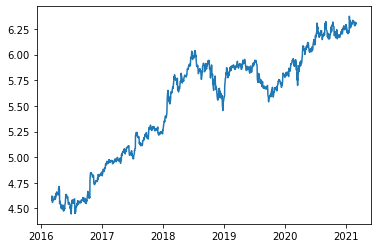

In [14]:
ts_log = np.log(ts)
plt.plot(ts_log)

## 데이터 분석하기

In [15]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.064950
p-value                           0.728845
#Lags Used                        8.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


In [16]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [17]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


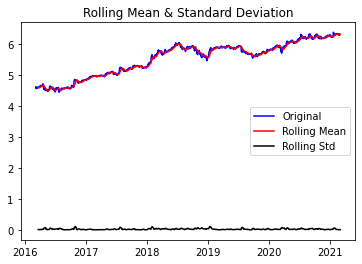

Results of Dickey-Fuller Test:
Test Statistic                   -1.064950
p-value                           0.728845
#Lags Used                        8.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


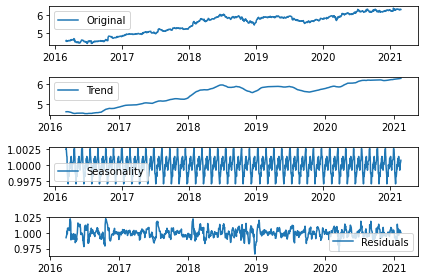

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

위의 그래프를 통해 평균은 계속 증가하고 있고, 계절성이 뚜렷하게 들어난다는 것이 넷플릭스 주식의 특징임을 유추할 수 있다. 

In [19]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.121803e+01
p-value                        2.046328e-20
#Lags Used                     1.800000e+01
Number of Observations Used    1.209000e+03
Critical Value (1%)           -3.435770e+00
Critical Value (5%)           -2.863934e+00
Critical Value (10%)          -2.568044e+00
dtype: float64


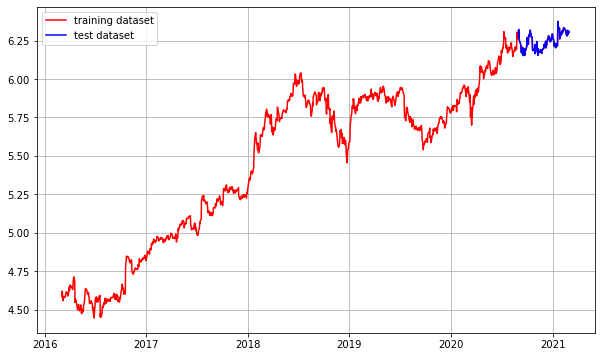

In [20]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

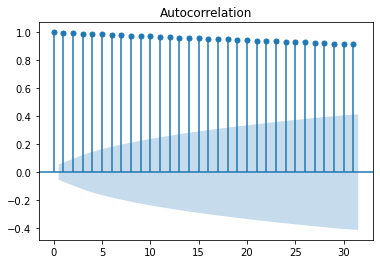

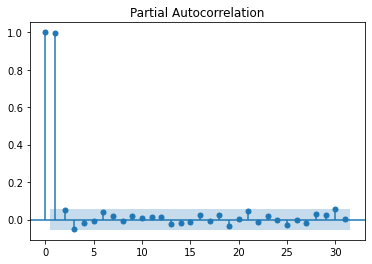

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.408742e+01
p-value                        2.759570e-26
#Lags Used                     7.000000e+00
Number of Observations Used    1.249000e+03
Critical Value (1%)           -3.435596e+00
Critical Value (5%)           -2.863857e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


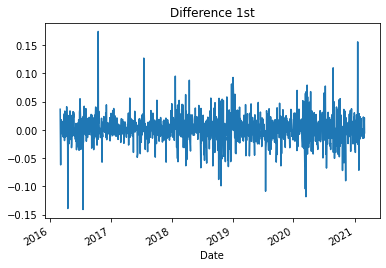

In [22]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.304830e+01
p-value                        2.168463e-24
#Lags Used                     2.100000e+01
Number of Observations Used    1.234000e+03
Critical Value (1%)           -3.435660e+00
Critical Value (5%)           -2.863885e+00
Critical Value (10%)          -2.568019e+00
dtype: float64


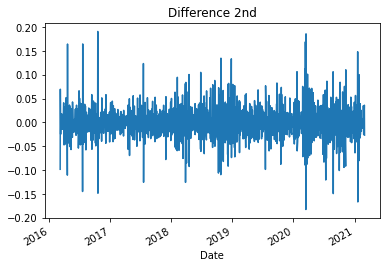

In [23]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 데이터 학습하기

p, d, q 값을 구하기 위해 각각 분석을 해 보았다. p의 경우 1, d는 1차 차분만 해도 충분할 것 같아서 1, q는 0으로 주고 모델을 학습한다.  

In [25]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2570.705
Method:                       css-mle   S.D. of innovations              0.025
Date:                Wed, 03 Mar 2021   AIC                          -5135.411
Time:                        20:54:17   BIC                          -5120.318
Sample:                             1   HQIC                         -5129.709
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.001      2.125      0.034       0.000       0.003
ar.L1.D.Close    -0.0634      0.030     -2.137      0.033      -0.122      -0.005
                                    Root

/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

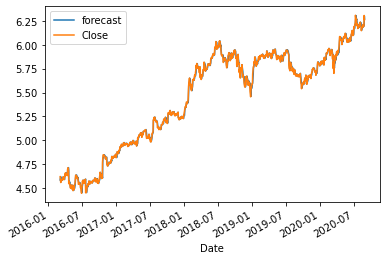

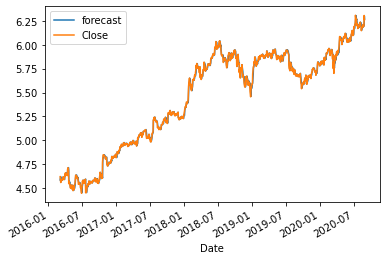

In [26]:
fitted_m.plot_predict()

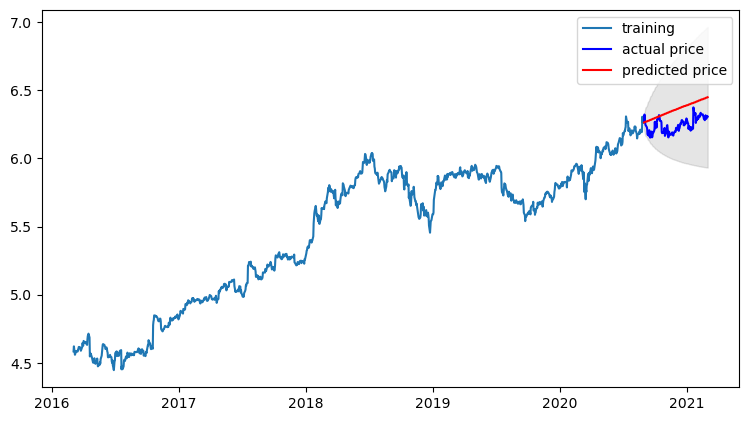

In [27]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4555.495772950413
MAE:  62.425884006522296
RMSE:  67.49441290173885
MAPE: 12.25%


12.25퍼센트의 MAPE를 보인다. q값을 좀 더 조정해보면 어떨까? 

In [68]:
# Build Model
model2 = ARIMA(train_data, order=(1, 1, 12))  
fitted_m2 = model2.fit(disp=-1)  
print(fitted_m2.summary())

/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                ARIMA(1, 1, 12)   Log Likelihood                2585.762
Method:                       css-mle   S.D. of innovations              0.025
Date:                Wed, 03 Mar 2021   AIC                          -5141.524
Time:                        22:04:19   BIC                          -5066.061
Sample:                             1   HQIC                         -5113.015
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0015      0.001      2.374      0.018       0.000       0.003
ar.L1.D.Close     -0.7957      0.191     -4.172      0.000      -1.170      -0.422
ma.L1.D.Close      0.7330      0.193

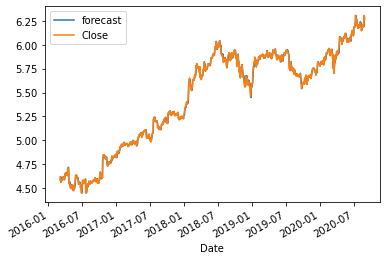

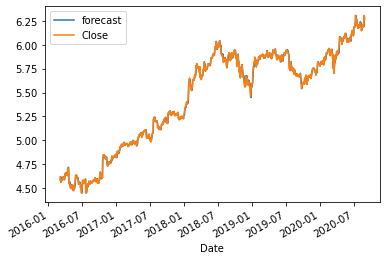

In [69]:
fitted_m2.plot_predict()

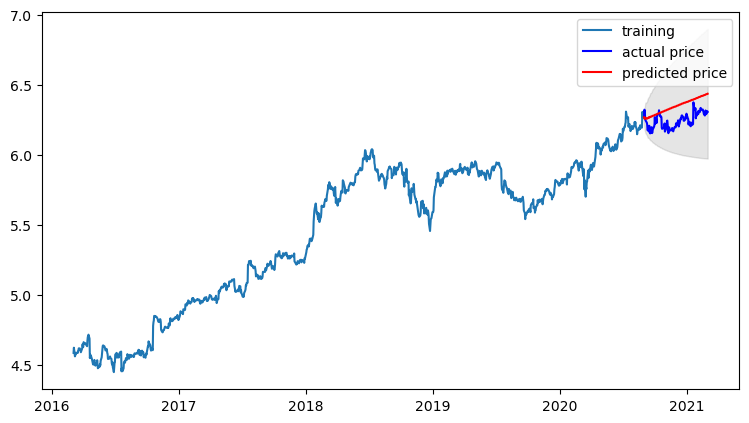

In [75]:
def forecast_stock(model,train_data,test_data) :
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = model.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(9,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    return fc,se,conf
fc, se, conf = forecast_stock(fitted_m2, train_data, test_data)

In [76]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3716.8988767715305
MAE:  55.71056216856095
RMSE:  60.96637496826862
MAPE: 10.94%


넷플릭스는 10.94퍼센트의 MAPE를 보이면서 끝났다. 

## 다른 데이터 가지고 실험하기

다른 데이터를 구해서 같은 분석을 시도한다. 이에 필요한 함수들을 먼저 정의한다. 

In [134]:
# 데이터 업로드 및 데이터 전처리
def data_trim(data_path) :
    df = pd.read_csv(data_path, index_col='Date', parse_dates=True)
    ts = df['Close']
    print(ts.head())
    
    list_nan = ts[ts.isna()]
    if len(list_nan) != 0 :
        ts=ts.interpolate(method='time')
    ts_log = np.log(ts)
    print(ts_log.head())
    plt.plot(ts_log)
    #plt.show(ts_log)
    return ts_log
# 데이터의 시계열적 특성을 보여주는 함수
def show_is_data_statistical(data) :
    augmented_dickey_fuller_test(data)
    plot_rolling_statistics(data)
    print("Time Series Decomposition")
    decomposition = seasonal_decompose(data, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return decomposition

# train과 test 데이터로 나누기
def train_test_split(data, percent=0.9) :
    train_data, test_data = data[:int(len(data)*percent)], data[int(len(data)*percent):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(train_data, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data, test_data
# ACE와 PACF 지표
def show_ACF_PACF(data) :
    plot_acf(data)
    plot_pacf(data)
    plt.show()
    
# 차분 구하기
def get_diff(data, order = 1) :
    
    diff_1 = data.diff(periods=1).iloc[1:]
    diff_1.plot(title = 'Difference 1st')
    augmented_dickey_fuller_test(diff_1)
    
    if order == 1 :
        return diff_1
    else :
        diff_2 = diff_1.diff(periods=1).iloc[1:]
        diff_2.plot(title = 'Difference 2nd')
        augmented_dickey_fuller_test(diff_2)
        return diff_2

#ARIMA 모델 빌드하고 학습하기
    
def get_arima_model(data,order = (1,1,0)) :
    model = ARIMA(data, order = order)
    fitted_m = model.fit(disp=-1)
    print(fitted_m.summary())
    fitted_m.plot_predict()
    return fitted_m

def forecast_stock(model,train_data,test_data) :
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = model.forecast(len(test_data), alpha=0.05)  # 95% conf
    print(fc)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(9,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    return fc_series,lower_series,upper_series

def get_arima_model_without_print(data,order = (1,1,0)) :
    model = ARIMA(data, order = order)
    fitted_m = model.fit(disp=-1)
    #print(fitted_m.summary())
    fitted_m.plot_predict()
    return fitted_m

def forecast_stock_without_print(model,train_data,test_data) :
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = model.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드
    
    return fc_series,lower_series,upper_series

#ARMIA 모델 예측결과 지표 출력하기
def get_predict_result(fc, se, conf, test_data) :
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))
    
    return {
        'RMSE' : rmse,
        'MAPE' : mape
    }

구글의 데이터를 가지고 분석해보았다. 

Date
2016-03-04    710.890015
2016-03-07    695.159973
2016-03-08    693.969971
2016-03-09    705.239990
2016-03-10    712.820007
Name: Close, dtype: float64
Date
2016-03-04    6.566518
2016-03-07    6.544142
2016-03-08    6.542429
2016-03-09    6.558538
2016-03-10    6.569229
Name: Close, dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -0.141439
p-value                           0.945151
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


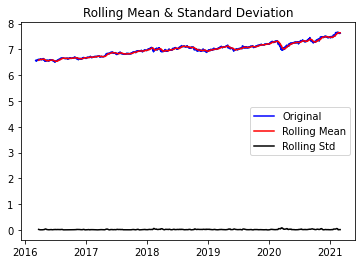

Time Series Decomposition


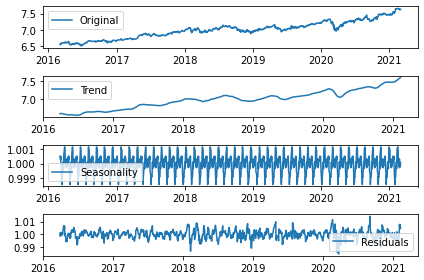

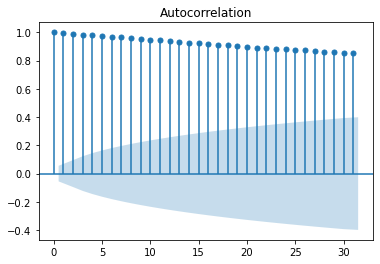

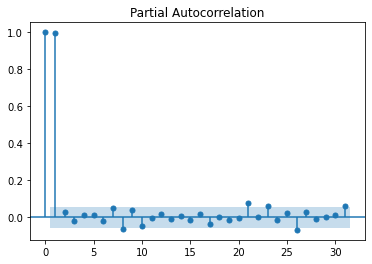

Results of Dickey-Fuller Test:
Test Statistic                -1.162865e+01
p-value                        2.290786e-21
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64
Date
2016-03-04    6.566518
2016-03-07    6.544142
2016-03-08    6.542429
2016-03-09    6.558538
2016-03-10    6.569229
                ...   
2020-08-25    7.382883
2020-08-26    7.409972
2020-08-27    7.398988
2020-08-28    7.405137
2020-08-31    7.398896
Name: Close, Length: 1132, dtype: float64 Date
2020-09-01    7.415000
2020-09-02    7.454882
2020-09-03    7.403573
2020-09-04    7.372143
2020-09-08    7.334584
                ...   
2021-02-25    7.616461
2021-02-26    7.619165
2021-03-01    7.640849
2021-03-02    7.638121
2021-03-03    7.627705
Name: Close, Length: 126, dtype: float64


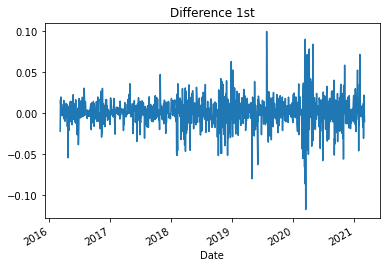

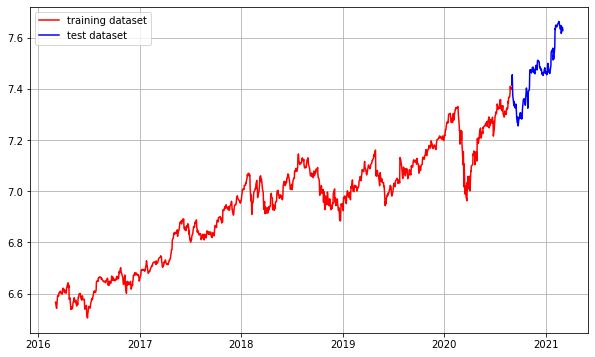

In [108]:
dataset_filepath_base = os.getenv('HOME') + '/aiffel/stock_prediction/data/'
dataset_amazon = dataset_filepath_base + 'GOOG.csv'
data_amz = data_trim(dataset_amazon)
show_is_data_statistical(data_amz)
show_ACF_PACF(data_amz)
get_diff(data_amz)
train_amz, test_amz = train_test_split(data_amz)
print(train_amz, test_amz)

Date
2016-03-04    6.566518
2016-03-07    6.544142
2016-03-08    6.542429
2016-03-09    6.558538
2016-03-10    6.569229
                ...   
2020-08-25    7.382883
2020-08-26    7.409972
2020-08-27    7.398988
2020-08-28    7.405137
2020-08-31    7.398896
Name: Close, Length: 1132, dtype: float64
Date
2020-09-01    7.415000
2020-09-02    7.454882
2020-09-03    7.403573
2020-09-04    7.372143
2020-09-08    7.334584
                ...   
2021-02-25    7.616461
2021-02-26    7.619165
2021-03-01    7.640849
2021-03-02    7.638121
2021-03-03    7.627705
Name: Close, Length: 126, dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3060.344
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 04 Mar 2021   AIC                          -6114.689
Time: 

/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

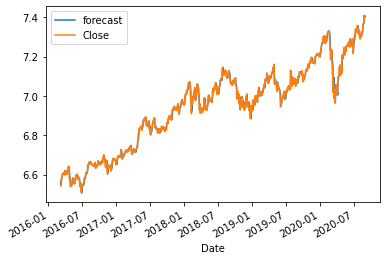

[7.40066671 7.40125385 7.40201572 7.40275179 7.40349166 7.40423098
 7.40497037 7.40570976 7.40644914 7.40718853 7.40792792 7.4086673
 7.40940669 7.41014608 7.41088546 7.41162485 7.41236424 7.41310362
 7.41384301 7.4145824  7.41532178 7.41606117 7.41680056 7.41753994
 7.41827933 7.41901871 7.4197581  7.42049749 7.42123687 7.42197626
 7.42271565 7.42345503 7.42419442 7.42493381 7.42567319 7.42641258
 7.42715197 7.42789135 7.42863074 7.42937012 7.43010951 7.4308489
 7.43158828 7.43232767 7.43306706 7.43380644 7.43454583 7.43528522
 7.4360246  7.43676399 7.43750338 7.43824276 7.43898215 7.43972154
 7.44046092 7.44120031 7.44193969 7.44267908 7.44341847 7.44415785
 7.44489724 7.44563663 7.44637601 7.4471154  7.44785479 7.44859417
 7.44933356 7.45007295 7.45081233 7.45155172 7.4522911  7.45303049
 7.45376988 7.45450926 7.45524865 7.45598804 7.45672742 7.45746681
 7.4582062  7.45894558 7.45968497 7.46042436 7.46116374 7.46190313
 7.46264252 7.4633819  7.46412129 7.46486067 7.46560006 7.466339

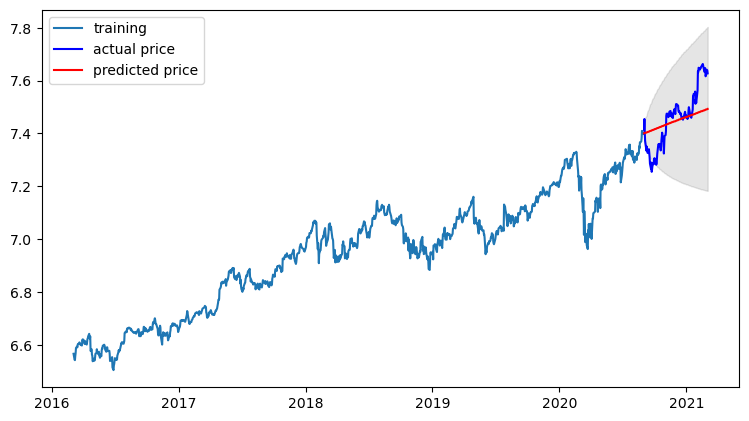

MSE:  24421.428491336497
MAE:  122.29713198934074
RMSE:  156.27356939462442
MAPE: 6.92%


In [111]:
print(train_amz)
print(test_amz)
model_amz = ARIMA(train_amz, order=(1, 1, 0))  
fitted_m = model_amz.fit(disp=-1)  
print(fitted_m.summary())
fitted_m.plot_predict()
plt.show()
fc, se, conf = forecast_stock(fitted_m,train_amz,test_amz)
get_predict_result(fc,se,conf,test_amz)

이번에는 마이크로소프트의 데이터를 가지고 왔다. p,d,q 값을 찾기 위해 grid search를 진행했다. 그 중에서 MAPE가 낮았던 결과를 취할 것이다. 

Date
2016-03-04    52.029999
2016-03-07    51.029999
2016-03-08    51.650002
2016-03-09    52.840000
2016-03-10    52.049999
Name: Close, dtype: float64
Date
2016-03-04    3.951820
2016-03-07    3.932414
2016-03-08    3.944490
2016-03-09    3.967268
2016-03-10    3.952205
Name: Close, dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -0.008188
p-value                           0.957850
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


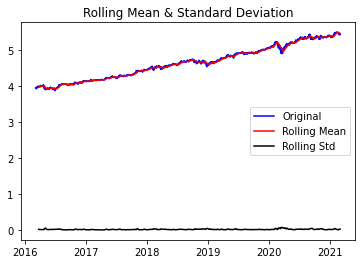

Time Series Decomposition


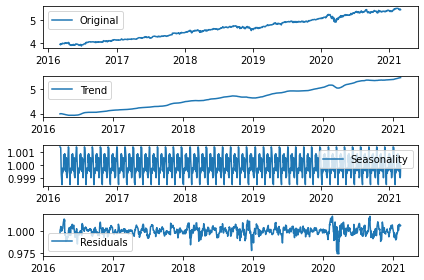

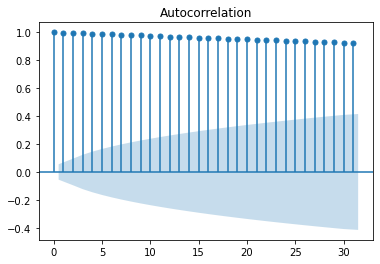

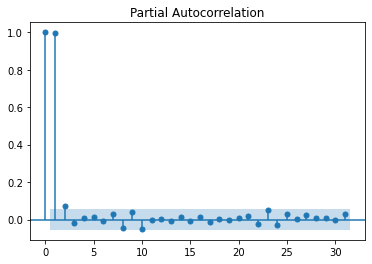

Results of Dickey-Fuller Test:
Test Statistic                -1.238940e+01
p-value                        4.827072e-23
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64
Date
2016-03-04    3.951820
2016-03-07    3.932414
2016-03-08    3.944490
2016-03-09    3.967268
2016-03-10    3.952205
                ...   
2020-08-25    5.377452
2020-08-26    5.398841
2020-08-27    5.423098
2020-08-28    5.433329
2020-08-31    5.418453
Name: Close, Length: 1132, dtype: float64
Date
2020-09-01    5.426139
2020-09-02    5.445228
2020-09-03    5.381279
2020-09-04    5.367144
2020-09-08    5.311530
                ...   
2021-02-25    5.433678
2021-02-26    5.448374
2021-03-01    5.467807
2021-03-02    5.454765
2021-03-03    5.440815
Name: Close, Length: 126, dtype: float64
                             ARIMA Model Result

/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

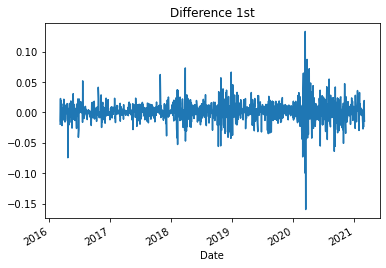

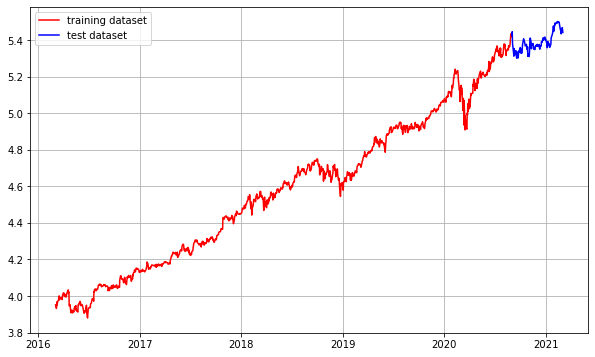

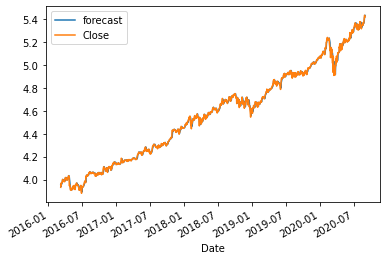

[5.42456028 5.42443881 5.42616623 5.42734482 5.42868633 5.42997948
 5.43128699 5.43259023 5.43389474 5.43519887 5.43650312 5.43780733
 5.43911155 5.44041577 5.44171999 5.44302421 5.44432843 5.44563265
 5.44693686 5.44824108 5.4495453  5.45084952 5.45215374 5.45345796
 5.45476218 5.4560664  5.45737062 5.45867484 5.45997906 5.46128327
 5.46258749 5.46389171 5.46519593 5.46650015 5.46780437 5.46910859
 5.47041281 5.47171703 5.47302125 5.47432546 5.47562968 5.4769339
 5.47823812 5.47954234 5.48084656 5.48215078 5.483455   5.48475922
 5.48606344 5.48736765 5.48867187 5.48997609 5.49128031 5.49258453
 5.49388875 5.49519297 5.49649719 5.49780141 5.49910563 5.50040985
 5.50171406 5.50301828 5.5043225  5.50562672 5.50693094 5.50823516
 5.50953938 5.5108436  5.51214782 5.51345204 5.51475625 5.51606047
 5.51736469 5.51866891 5.51997313 5.52127735 5.52258157 5.52388579
 5.52519001 5.52649423 5.52779845 5.52910266 5.53040688 5.5317111
 5.53301532 5.53431954 5.53562376 5.53692798 5.5382322  5.539536

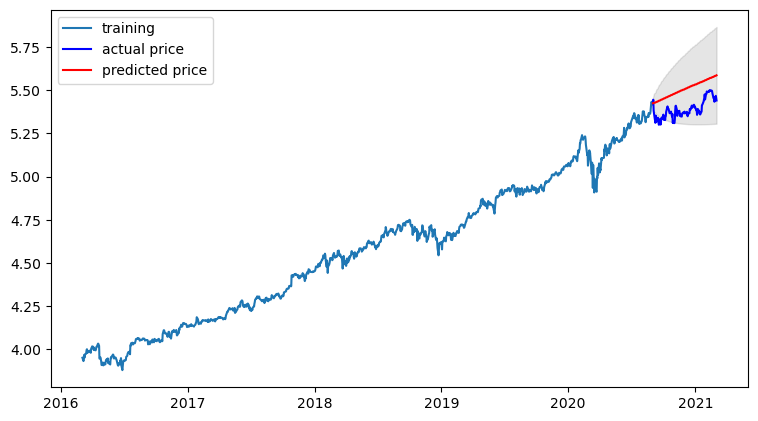

MSE:  788.3564864583828
MAE:  27.01193570602684
RMSE:  28.077686629392794
MAPE: 12.42%


In [116]:
dataset_filepath_base = os.getenv('HOME') + '/aiffel/stock_prediction/data/'
dataset_amazon = dataset_filepath_base + 'MSFT.csv'
data_amz = data_trim(dataset_amazon)
show_is_data_statistical(data_amz)
show_ACF_PACF(data_amz)
get_diff(data_amz)
train_amz, test_amz = train_test_split(data_amz)
print(train_amz)
print(test_amz)
model_amz = ARIMA(train_amz, order=(1, 1, 0))  
fitted_m = model_amz.fit(disp=-1)  
print(fitted_m.summary())
fitted_m.plot_predict()
plt.show()
fc, se, conf = forecast_stock(fitted_m,train_amz,test_amz)
get_predict_result(fc,se,conf,test_amz)

In [138]:
from tqdm.notebook import tqdm
def grid_search(train_data, test_data, p_range, d_range, q_range):
    scores = pd.DataFrame([], columns = ['p' , 'd', 'q', 'RMSE', 'MAPE'])
    orders = [(p, d, q) for p in p_range for q in q_range for d in d_range ]
      
    for order in orders:
        print(order)
        try:
            tmp_m = get_arima_model_without_print(train_data, order)
            fc_series_tmp, s, c = forecast_stock_without_print(tmp_m, train_data, test_data)
            tmp_m_acc = get_predict_result(fc_series_tmp, s, c, test_data)

            scores = scores.append({
                'p' : order[0],
                'd' : order[1],
                'q': order[2],
                'RMSE' : tmp_m_acc['RMSE'],
                'MAPE' : tmp_m_acc['MAPE']
            }, ignore_index=True)
        except ValueError:
            continue
    
    scores = scores.convert_dtypes()
    return scores

(1, 1, 0)
MSE:  788.3564864583828
MAE:  27.01193570602684
RMSE:  28.077686629392794
MAPE: 12.42%
(1, 2, 0)
MSE:  4316.275519359339
MAE:  54.431539746378384
RMSE:  65.69836770696315
MAPE: 24.15%
(1, 1, 3)
MSE:  801.5765148095473
MAE:  27.2452856265514
RMSE:  28.312126638766422
MAPE: 12.52%
(1, 2, 3)
MSE:  2492.259650709282
MAE:  47.0031100364329
RMSE:  49.92253650115629
MAPE: 21.32%
(1, 1, 5)
MSE:  769.2244680302929
MAE:  26.662725453423175
RMSE:  27.73489621452175
MAPE: 12.26%
(1, 2, 5)
MSE:  2074.434158225724
MAE:  43.13431506505155
RMSE:  45.54595655187982
MAPE: 19.60%
(1, 1, 10)
(1, 2, 10)
MSE:  1615.1355372635014
MAE:  38.2547159948893
RMSE:  40.18874888900501
MAPE: 17.42%
(2, 1, 0)
MSE:  791.5909099251966
MAE:  27.069922214631355
RMSE:  28.135225428725402
MAPE: 12.44%
(2, 2, 0)
MSE:  2336.304339989225
MAE:  45.78702876077611
RMSE:  48.3353322114292
MAPE: 20.79%
(2, 1, 3)
MSE:  778.0617772440006
MAE:  26.828194337726817
RMSE:  27.89375875073133
MAPE: 12.33%
(2, 2, 3)
MSE:  3586.226

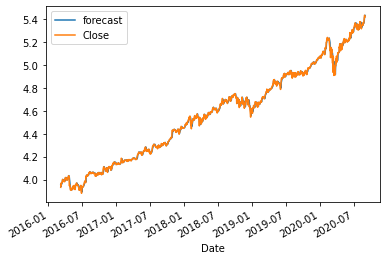

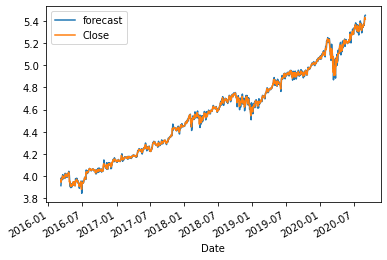

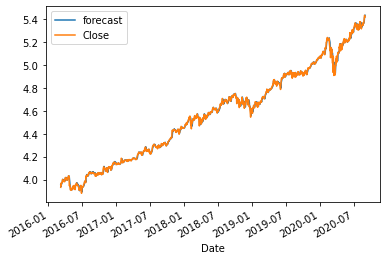

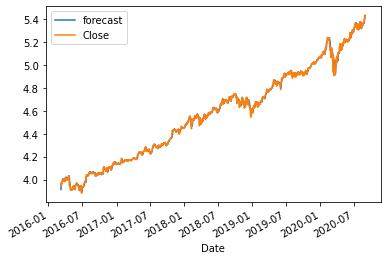

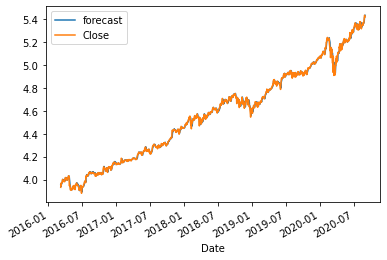

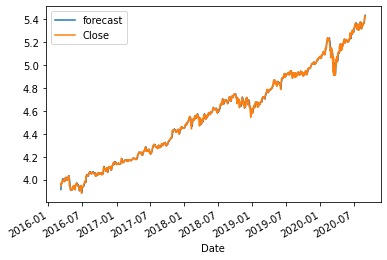

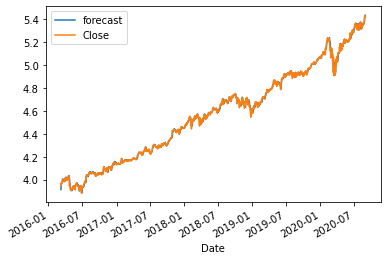

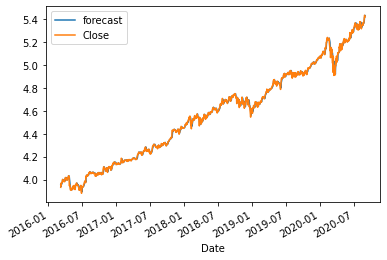

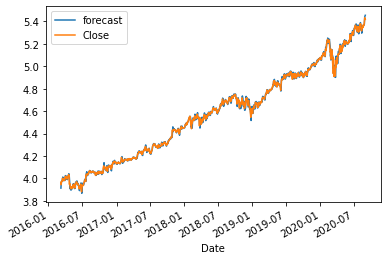

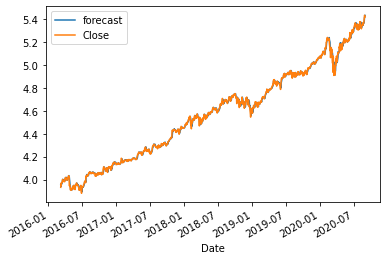

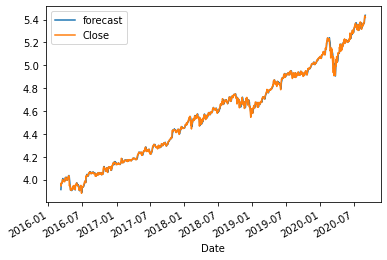

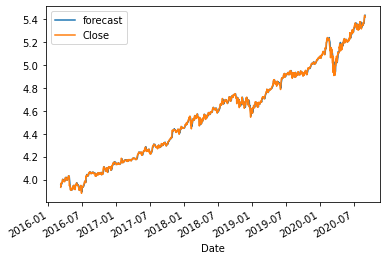

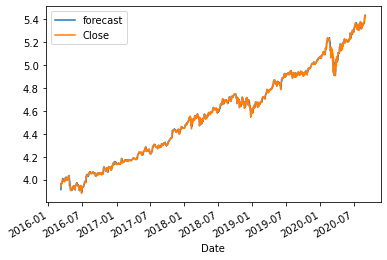

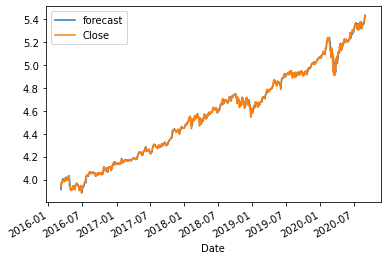

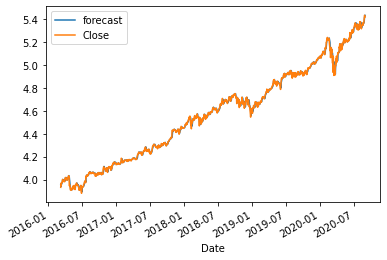

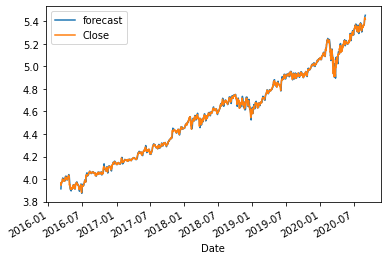

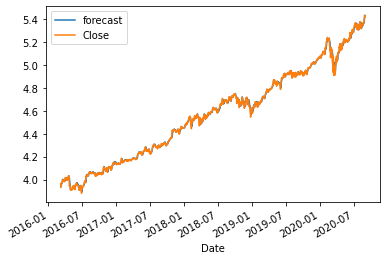

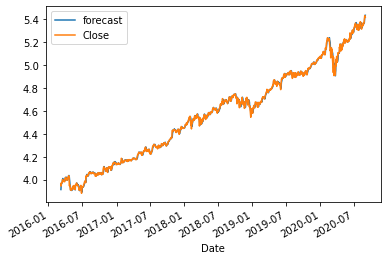

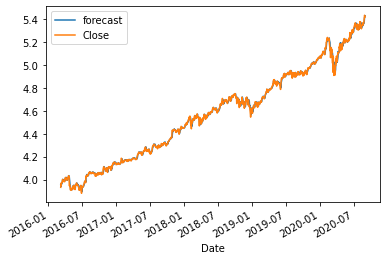

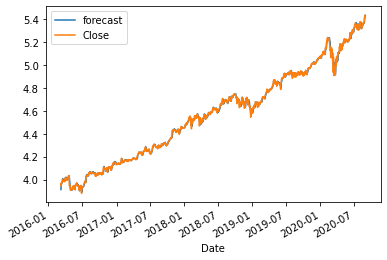

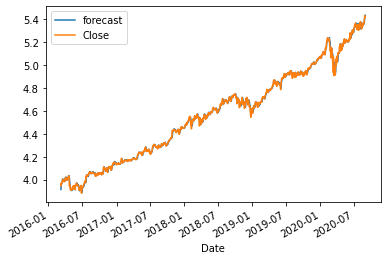

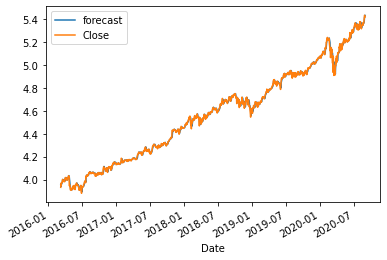

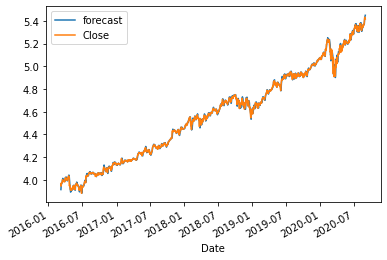

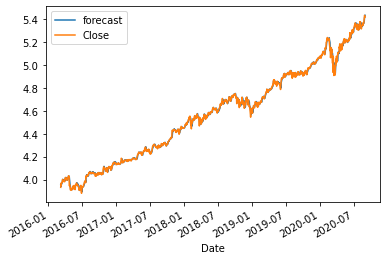

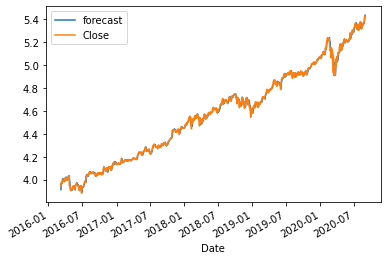

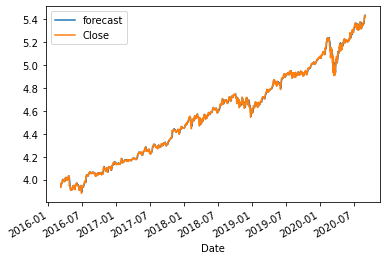

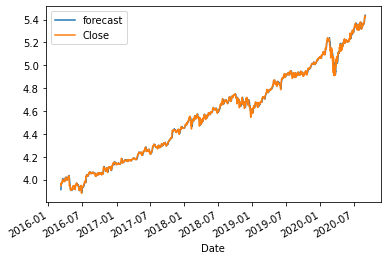

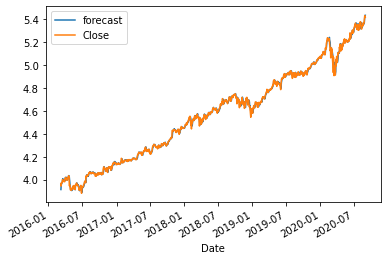

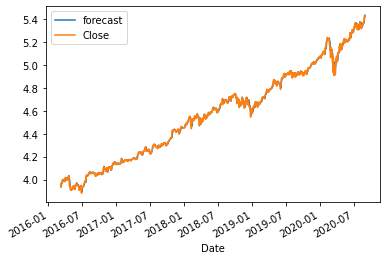

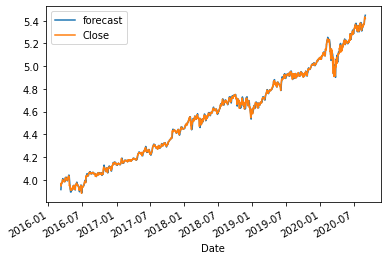

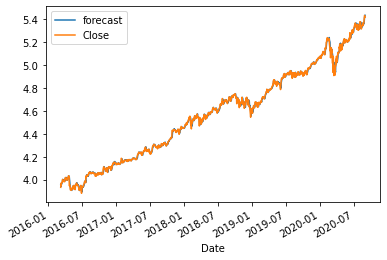

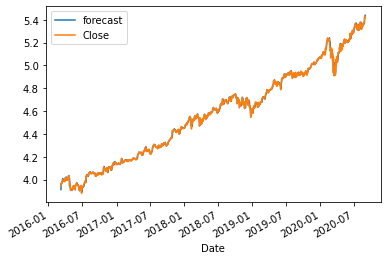

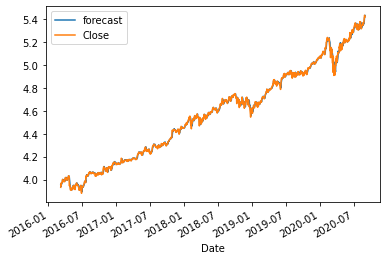

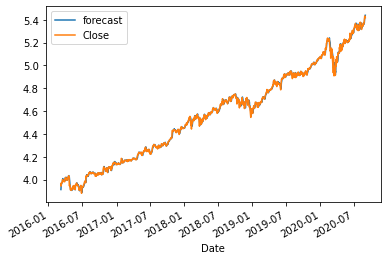

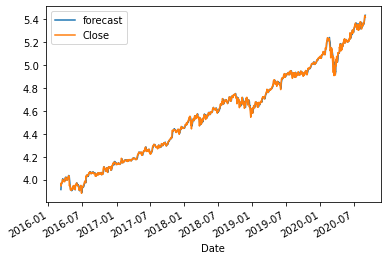

In [139]:
import warnings
warnings.filterwarnings("ignore")
scores = grid_search(train_amz, test_amz, [1,2,3,4,5], [1,2],[0,3,5,10])

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(5, 1, 5)   Log Likelihood                3075.857
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 04 Mar 2021   AIC                          -6127.713
Time:                        19:59:19   BIC                          -6067.343
Sample:                             1   HQIC                         -6104.906
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012   6.05e-05     20.605      0.000       0.001       0.001
ar.L1.D.Close    -1.4366      0.130    -11.079      0.000      -1.691      -1.182
ar.L2.D.Close    -0.4127      0.125     

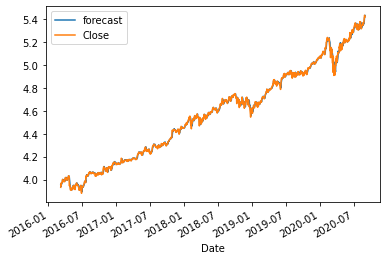

[5.41893424 5.41795136 5.41506549 5.41331022 5.41315118 5.41093694
 5.40896234 5.40906904 5.40676014 5.40588307 5.40484377 5.40381597
 5.40260579 5.40169213 5.40111611 5.39968466 5.39940598 5.39835658
 5.39773907 5.39707377 5.39641488 5.39596484 5.39519958 5.39501255
 5.3942904  5.3940596  5.39362591 5.39327485 5.39306387 5.39267654
 5.39262254 5.3922602  5.39225592 5.39204518 5.39198313 5.39196073
 5.39185979 5.39196771 5.39188944 5.39205736 5.39206926 5.39222918
 5.39237373 5.39250961 5.39276643 5.39291495 5.39323308 5.39344129
 5.39377395 5.3940738  5.3944002  5.39478969 5.39512463 5.39557314
 5.39594814 5.39642143 5.39686103 5.39734    5.39784853 5.39833656
 5.39889777 5.3994136  5.40000374 5.40056569 5.4011684  5.40178283
 5.40239622 5.40305528 5.40368939 5.40437759 5.40504514 5.40574946
 5.40645685 5.40717316 5.40791727 5.40865022 5.40942141 5.41017924
 5.41096777 5.41175593 5.41255712 5.41337498 5.41419032 5.41503217
 5.41586663 5.4167255  5.41758325 5.4184548  5.41933637 5.4202

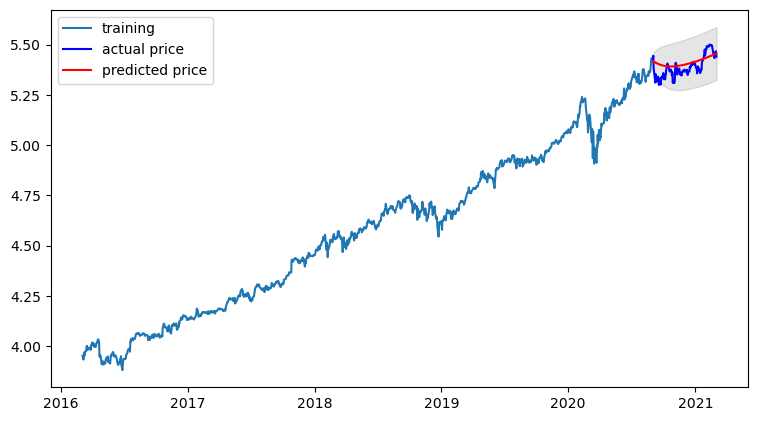

MSE:  99.56812343933181
MAE:  8.363702364030118
RMSE:  9.97838280681453
MAPE: 3.88%


{'RMSE': 9.97838280681453, 'MAPE': 0.03881140651794591}

In [140]:
model_amz = ARIMA(train_amz, order=(5, 1, 5))  
fitted_m = model_amz.fit(disp=-1)  
print(fitted_m.summary())
fitted_m.plot_predict()
plt.show()
fc, se, conf = forecast_stock(fitted_m,train_amz,test_amz)
get_predict_result(fc,se,conf,test_amz)

구글은 6퍼센트, 마이크로소프트는 3퍼센트의 MAPE를 보이면서 실험은 끝났다. 

# 회고
시계열은 그냥 시간에 따라 흘러가는 데이터를 다루는 일을 의미하는 줄 알았는데, 그 이상의 것들이 들어있음을 시계열 관련 두 노드에서 확인했다. 이번 노드에서는 시계열 데이터의 특성을 파악하는 방법을 배우면서 끝이 났다 시간이 되면 ARIMA 모델에 대한 개요도 확인할 것. 
ref )https://www.youtube.com/watch?v=ma_L2YRWMHI&feature=youtu.be 